In [45]:
#!pip3 install imagecodecs
#!pip3 install numpy tensorflow matplotlib scipy
#!pip3 install pandas
#!pip3 install tifffile
#!pip3 install -U scikit-learn scipy matplotlib
#!pip3 install tensorflow-addons
#!pip3 install tensorflow_decision_forests --upgrade

In [46]:
import math
import matplotlib
import matplotlib.pyplot as plt

import numpy as np

import os

import pandas as pd

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_decision_forests as tfdf
import tifffile
from keras.layers import Flatten, Dense, Dropout
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import concatenate

import scipy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [47]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
   # plt.plot(history.history['accuracy'], label='accuracy')
   # plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.ylim([0, 
            max(
                max(history.history['loss']),
                max(history.history['val_loss'])
            )])
    plt.xlabel('Epoch')
    plt.ylabel('Mean Absolute Error')
    plt.legend()
    plt.grid(True)

In [48]:
tiles = pd.read_csv(r'Data/Tiles_expanded.csv')
tiles_expanded_rv = pd.read_csv(r'Data/Tiles_expanded_road_vector.csv').drop(['Unnamed: 0'],axis=1)
tiles_expanded_rv = pd.get_dummies(tiles_expanded_rv, columns = ['RTTYP'])

In [49]:
tiles_expanded_rv.head()

,Tile_ID,Long2,Lat2,Long1,Lat1,Mid_lat,Mid_long,Stop_Signs,Paving_historical,Paving_future,Bus_stop,Collisions_Future,Collisions_Historical,RTTYP_I,RTTYP_M,RTTYP_O,RTTYP_S,RTTYP_U
0,36,-122.514446,37.779636,-122.513306,37.778732,37.779184,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
1,37,-122.514446,37.778732,-122.513306,37.777829,37.778280,-122.513876,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
2,151,-122.513306,37.779636,-122.512166,37.778732,37.779184,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
3,152,-122.513306,37.778732,-122.512166,37.777829,37.778280,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0
4,153,-122.513306,37.777829,-122.512166,37.776925,37.777377,-122.512736,0.0,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0


In [50]:
tiles_expanded_rv['Collisions_Future_binary']=tiles_expanded_rv['Collisions_Future'].apply(lambda x: 1 if x > 0 else 0)
tiles_expanded_rv['Collisions_Historical_binary']=tiles_expanded_rv['Collisions_Historical'].apply(lambda x: 1 if x > 0 else 0)

# Normalize data

In [51]:
def normalize_col(df, col_name):

    norm = (df[col_name] - df[col_name].min()) / (df[col_name].max() - df[col_name].min())
    return norm

tiles_expanded_rv['Mid_lat_norm'] = normalize_col(tiles_expanded_rv,'Mid_lat')
tiles_expanded_rv['Mid_long_norm'] = normalize_col(tiles_expanded_rv,'Mid_long')


Split into training and test

In [52]:
MODEL_TYPE='logistic' # 'linear'

if MODEL_TYPE == 'linear':
    input_x = ['Tile_ID','Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = tiles_expanded_rv['Collisions_Future']
elif MODEL_TYPE == 'logistic':
    input_x = ['Tile_ID','Collisions_Historical_binary', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']
    input_y = ['Collisions_Future_binary']
    

x_train, x_test, y_train, y_test = train_test_split(
                                    tiles_expanded_rv[input_x], 
                                    tiles_expanded_rv[input_y],
                                    random_state=104, 
                                    test_size=0.20, 
                                    shuffle=True)



In [53]:
# np.asarray(x_train[['Collisions_Historical', 'Mid_lat_norm','Mid_long_norm', 'Stop_Signs', 'Paving_historical', 'Bus_stop','RTTYP_I','RTTYP_M','RTTYP_O','RTTYP_S','RTTYP_U']]).astype('float32').shape

Model #1: Linear regression using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates

## Image Pre-Processing

In [54]:
IMAGE_PATH = '../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/' 

In [55]:
#eda
img = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/36.tif')[0:148, 0:188, :]
img2 = tifffile.imread('../210_Capstone_Aditya_Arisa_Noriel/Satellite Imagery/Satellite Images Tiled/37.tif')[0:148, 0:188, :]

In [56]:
# eda
print(np.shape(img2))

(148, 188, 4)


In [57]:
# eda
test = []
test.append(img[0:148, 0:188, :])
test.append(img2[0:148, 0:188, :])
print(np.shape(test))
test = np.stack(test)
print(np.shape(test))

(2, 148, 188, 4)
(2, 148, 188, 4)


In [58]:
#example of accessing RGB digits and storing average in a list

list_ = []

print(img[0][0])
print([np.mean(img[0][0][0:3]), img[0][0][3]])

for i in img:
    for j in i:
        list_.append([np.mean(j[0:3]), j[3]])

print(list_[0])

[185. 177. 160. 130.]
[174.0, 130.0]
[174.0, 130.0]


In [59]:
def preprocess_data_part1(IMAGE_PATH):
    """ Generate lists of images and labelsbased on temp_no_refer and temp_refer lists
    
    Params:
    -------
    IMAGE_PATH (str): path to directory with images.
    
    Returns:
    --------
    images_mini  (np.ndarray): Images of shape (N, 149 3)
    """
    
    data_mini = []
    
    for id in x_train['Tile_ID']:    
                    
        # read image and store as matrix            
        # Index at the end makes all images the same size (they sometimes differ by 1 pixel)
        image = tifffile.imread(IMAGE_PATH + str(id) + '.tif')[0:148, 0:188, :]
        
        #image_grayscale = []

        #for i in image:
        #    for j in i:
        #        image_grayscale.append([np.mean(j[0:3]), j[3]])
            
        # append to images
        data_mini.append(np.mean(image))
 
    # stack images and trasnform to array
    images_mini = np.stack(data_mini)
    
    return images_mini

In [60]:
# THERE IS ONE FILE IN THE "SATELLITE IMAGES TILED" FOLDER THAT IS NOT A TIF IMAGE, DELETE THIS FILE
images_mini = preprocess_data_part1(IMAGE_PATH)

In [61]:
np.shape(images_mini)

(8376,)

In [62]:
images_mini

array([125.19414, 130.83464, 145.29156, ..., 153.39537, 129.47469,
       121.93695], dtype=float32)

In [63]:
# images_mini_reshaped = images_mini.reshape((8376,1,1,111296))

In [64]:
# images_mini_reshaped.shape
# len(images_mini_reshaped[0][0][0])

Street Data Pre-Processing

In [65]:
street = np.asarray(x_train[input_x[1:]]).astype('float32')
street_mini = []
for row in street:
    street_mini.append([[row]])
street_mini = np.stack(street_mini)
np.shape(street_mini)

(8376, 1, 1, 11)

In [66]:
street_mini_reshaped = street_mini.reshape(8376,11)
np.shape(street_mini_reshaped)

(8376, 11)

In [67]:
images_mini_reshaped = images_mini.reshape(8376,1)
np.shape(images_mini_reshaped)

(8376, 1)

In [68]:
input_image_street = np.hstack((street_mini_reshaped, images_mini_reshaped))


In [69]:
# input_image_street = input_image_street.reshape((8376,1,1, 111307))

In [70]:
input_image_street[0]

array([  1.        ,   0.40708277,   0.69343007,   0.        ,
         0.        ,   0.        ,   0.        ,   1.        ,
         0.        ,   0.        ,   0.        , 125.19414   ],
      dtype=float32)

In [71]:
input_image_street.shape
# y_train.shape

(8376, 12)

In [72]:
np.shape(y_train)

(8376, 1)

**Model #3: Random Forest using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab
https://www.youtube.com/watch?v=5qgk9QJ4rdQ&t=181s

In [73]:
# Train a Random Forest model.

rf_model = tfdf.keras.RandomForestModel(task=2)

rf_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpcnfqv8p5 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.326788. Found 8376 examples.
Training model...


[INFO 2023-03-15T02:28:20.978344039+00:00 kernel.cc:1214] Loading model from path /tmp/tmpcnfqv8p5/model/ with prefix 3c72b4f133c74b76


Model trained in 0:00:03.006196
Compiling model...


[INFO 2023-03-15T02:28:21.709050855+00:00 decision_forest.cc:661] Model loaded with 300 root(s), 278780 node(s), and 11 input feature(s).
[INFO 2023-03-15T02:28:21.70909374+00:00 abstract_model.cc:1311] Engine "RandomForestOptPred" built
[INFO 2023-03-15T02:28:21.709117206+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [74]:
print(rf_model.summary())

Model: "random_forest_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.0"  0.468187 ################
    2.  "data:0.3"  0.315831 #########
    3.  "data:0.2"  0.229193 ######
    4.  "data:0.5"  0.222719 #####
    5.  "data:0.1"  0.189987 ####
    6. "data:0.11"  0.154526 ##
    7.  "data:0.4"  0.102119 
    8.  "data:0.7"  0.085081 
    9. "data:0.10"  0.084205 
   10.  "data:0.9"  0.083766 
   11.  "data:0.6"  0.083294 

Variable Importance: NUM_AS_ROOT:
    1.  "data:0.0" 130.000000 ################
   

In [75]:
##uncomment to show training log
#rf_model_train.make_inspector().training_logs()
rf_model.make_inspector().evaluation()

Evaluation(num_examples=8376, accuracy=None, loss=None, rmse=0.32093074703642993, ndcg=None, aucs=None, auuc=None, qini=None)

In [76]:
#evaluate the model
#rf_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

In [77]:
#make predictions from test set
#pd.DataFrame(rf_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))

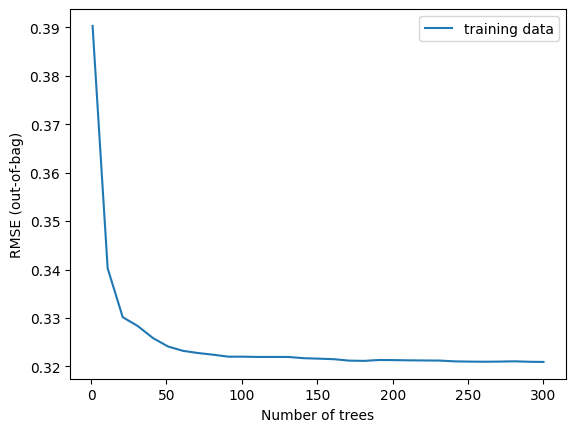

In [78]:
import matplotlib.pyplot as plt

logs = rf_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("RMSE (out-of-bag)")
plt.legend()
plt.show()

**Model #4: Gradient Boosted Tree using Historical Collisions, SFMTA Street Characteristics, and Geocoordinates**

Helpful sources:

https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/GradientBoostedTreesModel
https://www.tensorflow.org/decision_forests/tutorials/beginner_colab

In [79]:
gbt_model = tfdf.keras.GradientBoostedTreesModel(task=2)

gbt_model.fit(input_image_street,
    y_train,
    #validation_data=[x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']], y_test],     
    epochs=1,
    verbose=1)

Use /tmp/tmpkt_qqyi3 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.323967. Found 8376 examples.
Training model...


2023-03-15 02:28:22.624403: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1790] "goss_alpha" set but "sampling_method" not equal to "GOSS".
2023-03-15 02:28:22.624445: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1800] "goss_beta" set but "sampling_method" not equal to "GOSS".
2023-03-15 02:28:22.624455: W external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1814] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
2023-03-15 02:28:22.624911: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:452] Default loss set to SQUARED_ERROR
2023-03-15 02:28:22.624958: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1077] Training gradient boosted tree on 8376 example(s) and 12 feature(s).
2023-03-15 02:28:22.625837: I 

Model trained in 0:00:00.786723
Compiling model...


2023-03-15 02:28:23.385912: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:1568] Create final snapshot of the model at iteration 74
2023-03-15 02:28:23.388537: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:247] Truncates the model to 45 tree(s) i.e. 45  iteration(s).
2023-03-15 02:28:23.388726: I external/ydf/yggdrasil_decision_forests/learner/gradient_boosted_trees/gradient_boosted_trees.cc:309] Final model num-trees:45 valid-loss:0.311951 valid-rmse:0.311951
[INFO 2023-03-15T02:28:23.39956256+00:00 kernel.cc:1214] Loading model from path /tmp/tmpkt_qqyi3/model/ with prefix 5f18cd3a11534744
[INFO 2023-03-15T02:28:23.405688084+00:00 kernel.cc:1046] Use fast generic engine


Model compiled.


In [80]:
print(gbt_model.summary())

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: REGRESSION
Label: "__LABEL"

Input Features (12):
	data:0.0
	data:0.1
	data:0.10
	data:0.11
	data:0.2
	data:0.3
	data:0.4
	data:0.5
	data:0.6
	data:0.7
	data:0.8
	data:0.9

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.  "data:0.0"  0.424873 ################
    2.  "data:0.3"  0.309196 ########
    3.  "data:0.5"  0.256201 #####
    4.  "data:0.2"  0.247375 ####
    5.  "data:0.1"  0.215822 ##
    6. "data:0.11"  0.215260 ##
    7.  "data:0.4"  0.189063 #
    8. "data:0.10"  0.172113 
    9.  "data:0.7"  0.171738 

Variable Importance: NUM_AS_ROOT:
    1. "data:0.0" 32.000000 ################
    2. "data:0.3"  5.000000 #
    3. "data:0.5"  5.

In [81]:
##uncomment to show training log
#gbt_model.make_inspector().training_logs()
gbt_model.make_inspector().evaluation()

Evaluation(num_examples=None, accuracy=None, loss=0.31195101141929626, rmse=0.31195101141929626, ndcg=None, aucs=None, auuc=None, qini=None)

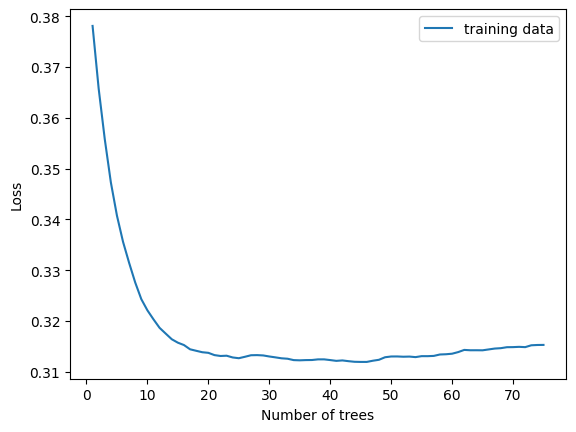

In [82]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()

plt.show()

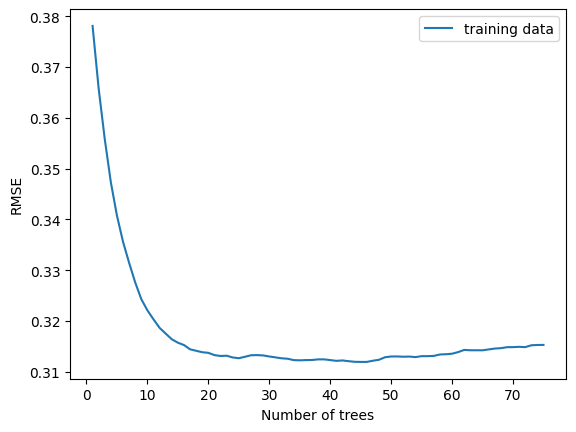

In [83]:
import matplotlib.pyplot as plt

logs = gbt_model.make_inspector().training_logs()

plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs], label="training data")
plt.xlabel("Number of trees")
plt.ylabel("RMSE")
plt.legend()

plt.show()

In [84]:
#evaluate the model
#gbt_model.evaluate(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']])

In [85]:
#make predictions from test set
#pd.DataFrame(gbt_model.predict(x_test[['Collisions_Historical', 'Mid_lat','Mid_long', 'Stop_Signs', 'Paving_historical', 'Bus_stop']]))